In [17]:
import requests, json
import numpy as np
import pandas as pd
from pandas.io import sql
import sqlite3
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [18]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data mining

In [19]:
# Get call to the end point "https://min-api.cryptocompare.com/data/histohour":

cryptocompare_url = 'https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&aggregate=1&e=CCCAGG'

r_ = requests.get(cryptocompare_url)

Used cryptocompare as widely popular and easy to use, average price of multiple exchanges

In [20]:
# Transform the data from text to a JSON object:
json_ = r_.json()
print(json_)

{'Response': 'Success', 'Type': 100, 'Aggregated': False, 'Data': [{'time': 1364083200, 'close': 71.5, 'high': 72.5, 'low': 62.7, 'open': 64.35, 'volumefrom': 42023.26, 'volumeto': 2896432.3}, {'time': 1364169600, 'close': 73.6, 'high': 78, 'low': 69.52, 'open': 71.5, 'volumefrom': 79743.02, 'volumeto': 5921197.54}, {'time': 1364256000, 'close': 78.5, 'high': 79.72, 'low': 73.11, 'open': 73.6, 'volumefrom': 56667.38, 'volumeto': 4377374.22}, {'time': 1364342400, 'close': 88.92, 'high': 89.5, 'low': 78.4, 'open': 78.5, 'volumefrom': 72226.75, 'volumeto': 6129700.26}, {'time': 1364428800, 'close': 86.18, 'high': 95.7, 'low': 75, 'open': 88.92, 'volumefrom': 140263.09, 'volumeto': 12261153.08}, {'time': 1364515200, 'close': 90.5, 'high': 93.06, 'low': 83.01, 'open': 86.18, 'volumefrom': 83174.56, 'volumeto': 7384104.11}, {'time': 1364601600, 'close': 92.19, 'high': 94.98, 'low': 87, 'open': 90.5, 'volumefrom': 37284.61, 'volumeto': 3420002.53}, {'time': 1364688000, 'close': 93.03, 'high':

In [21]:
# Inspect the object keys 
json_.keys()

dict_keys(['Response', 'Type', 'Aggregated', 'Data', 'TimeTo', 'TimeFrom', 'FirstValueInArray', 'ConversionType'])

In [22]:
# Select the only data needed for the analysis
clean_json = json_['Data']

In [23]:
# Transform the json file into a pandas dataframe and visually inspect it 
BTC_price = pd.DataFrame(clean_json)
BTC_price.head()

,close,high,low,open,time,volumefrom,volumeto
0,71.50,72.50,62.70,64.35,1364083200,42023.26,2896432.30
1,73.60,78.00,69.52,71.50,1364169600,79743.02,5921197.54
2,78.50,79.72,73.11,73.60,1364256000,56667.38,4377374.22
3,88.92,89.50,78.40,78.50,1364342400,72226.75,6129700.26
4,86.18,95.70,75.00,88.92,1364428800,140263.09,12261153.08


In [24]:
BTC_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 7 columns):
close         2001 non-null float64
high          2001 non-null float64
low           2001 non-null float64
open          2001 non-null float64
time          2001 non-null int64
volumefrom    2001 non-null float64
volumeto      2001 non-null float64
dtypes: float64(6), int64(1)
memory usage: 109.5 KB


In [25]:
BTC_price.describe()

,close,high,low,open,time,volumefrom,volumeto
count,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03,2001.000000,2.001000e+03
mean,2095.405107,2166.815442,2006.327801,2092.311544,1.450483e+09,63778.449350,2.142187e+08
std,3367.476612,3502.692013,3193.481132,3366.506552,4.992047e+07,59798.758208,4.940128e+08
min,68.360000,72.500000,50.010000,64.350000,1.364083e+09,0.000000,0.000000e+00
25%,281.720000,289.810000,274.190000,281.600000,1.407283e+09,22917.660000,7.984589e+06
50%,573.940000,582.730000,560.350000,573.880000,1.450483e+09,49604.160000,2.023868e+07
75%,1445.930000,1471.140000,1394.830000,1415.810000,1.493683e+09,86145.830000,1.542891e+08
max,19345.490000,19870.620000,18750.910000,19346.600000,1.536883e+09,572349.320000,6.245732e+09


In [26]:
# Further inspect the dataframe
BTC_price.shape

(2001, 7)

In [27]:
# Change the time column from unix to a datetime object
BTC_price['Time'] = pd.to_datetime(BTC_price.time, errors='coerce', unit = 's')

In [28]:
# Drop the previous unix time version
BTC_price.drop('time', axis=1, inplace=True)

In [29]:
BTC_price = BTC_price.sort_values('Time')
BTC_price.reset_index(drop=True, inplace=True)
BTC_price.set_index('Time',inplace=True,drop=True)
BTC_price.index.name = None
BTC_price.head(10)

,close,high,low,open,volumefrom,volumeto
2013-03-24,71.50,72.50,62.70,64.35,42023.26,2896432.30
2013-03-25,73.60,78.00,69.52,71.50,79743.02,5921197.54
2013-03-26,78.50,79.72,73.11,73.60,56667.38,4377374.22
2013-03-27,88.92,89.50,78.40,78.50,72226.75,6129700.26
2013-03-28,86.18,95.70,75.00,88.92,140263.09,12261153.08
2013-03-29,90.50,93.06,83.01,86.18,83174.56,7384104.11
2013-03-30,92.19,94.98,87.00,90.50,37284.61,3420002.53
2013-03-31,93.03,93.80,91.00,92.19,21129.50,1959050.82
2013-04-01,104.00,106.00,92.24,93.03,90563.17,9060022.27
2013-04-02,117.98,118.36,99.00,104.00,81284.67,8747147.45


# Exploratory Data Analysis

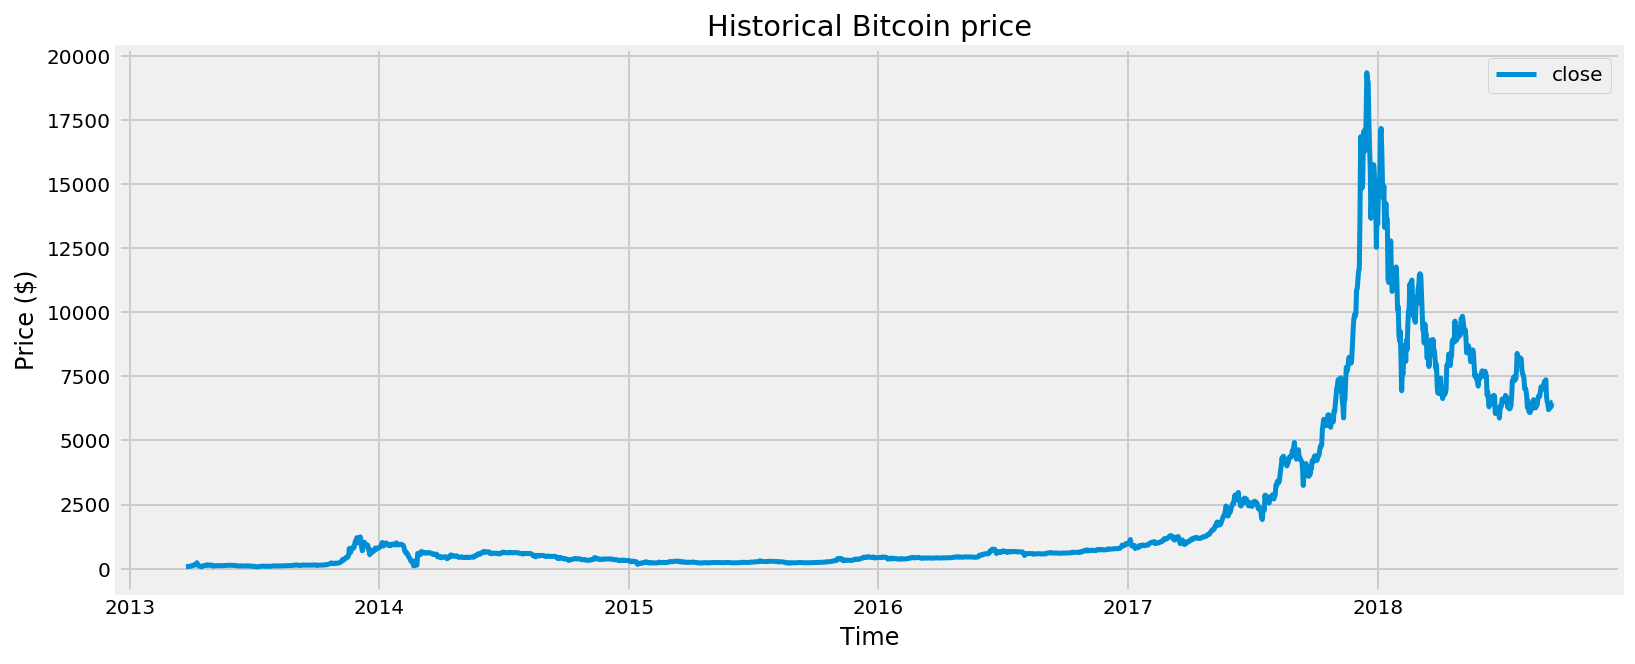

In [30]:
BTC_price[['close']].plot(lw=2.5, figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title('Historical Bitcoin price')
plt.show()

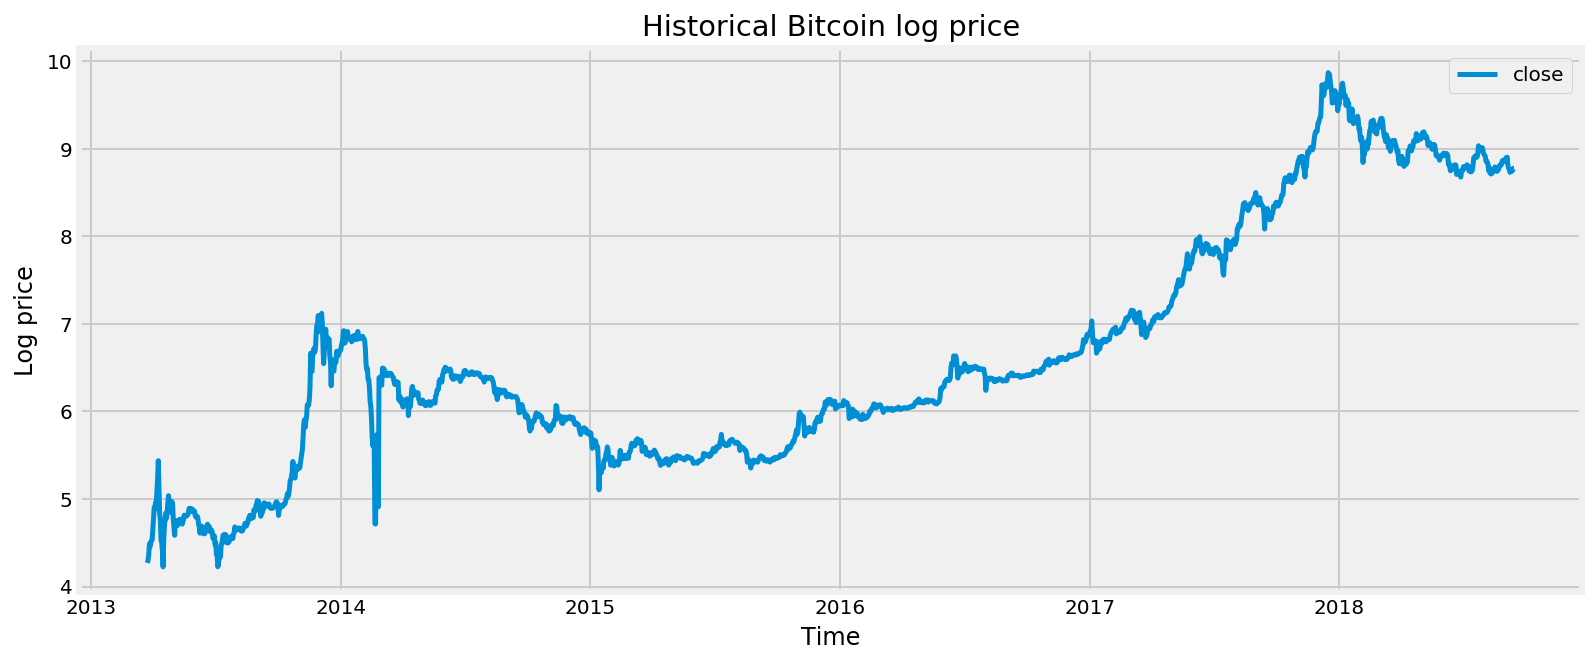

In [31]:
np.log(BTC_price[['close']]).plot(lw=2.5, figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Log price')
plt.title('Historical Bitcoin log price')
plt.show()

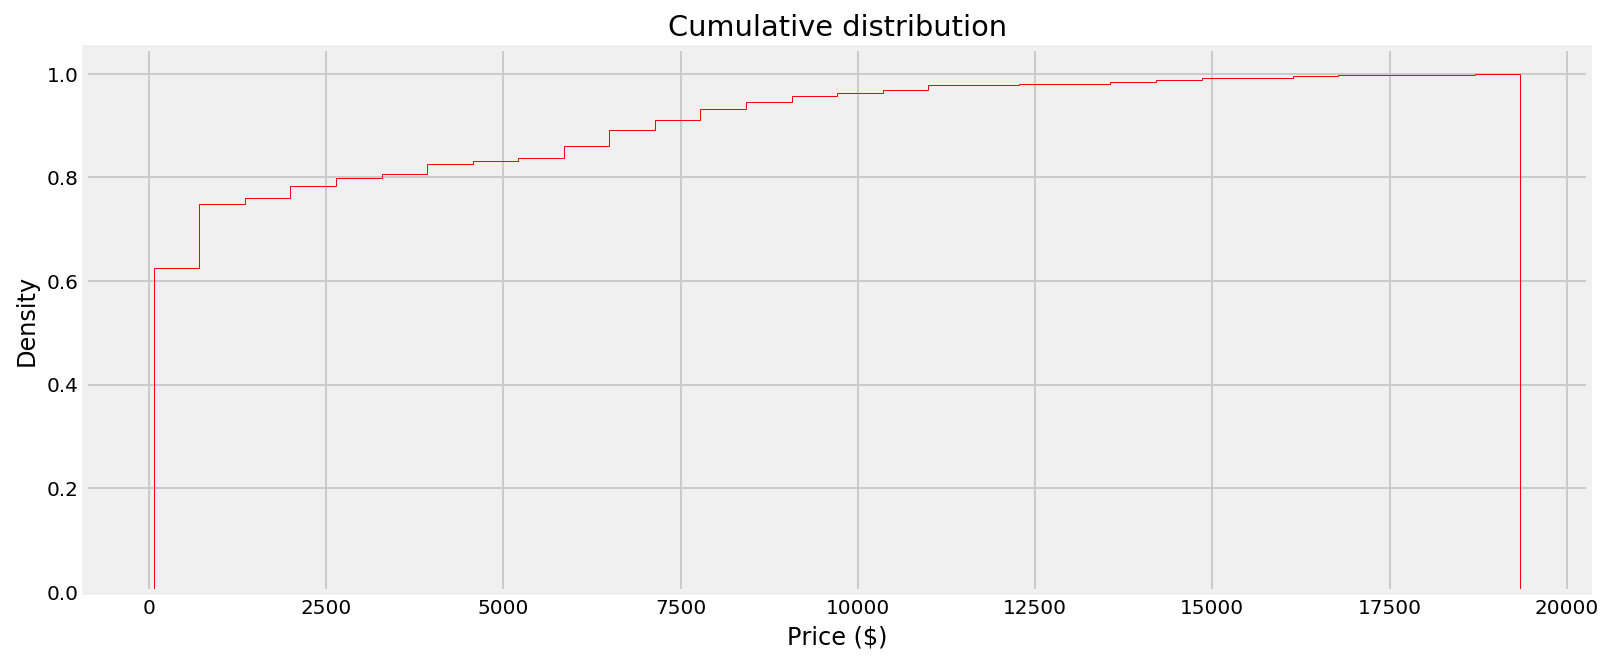

In [32]:
BTC_price['close'].hist(bins=30, density=True, histtype='step', color='r', cumulative=True, figsize=(12,5))
plt.xlabel('Price ($)')
plt.ylabel('Density')
plt.title('Cumulative distribution')
plt.show()

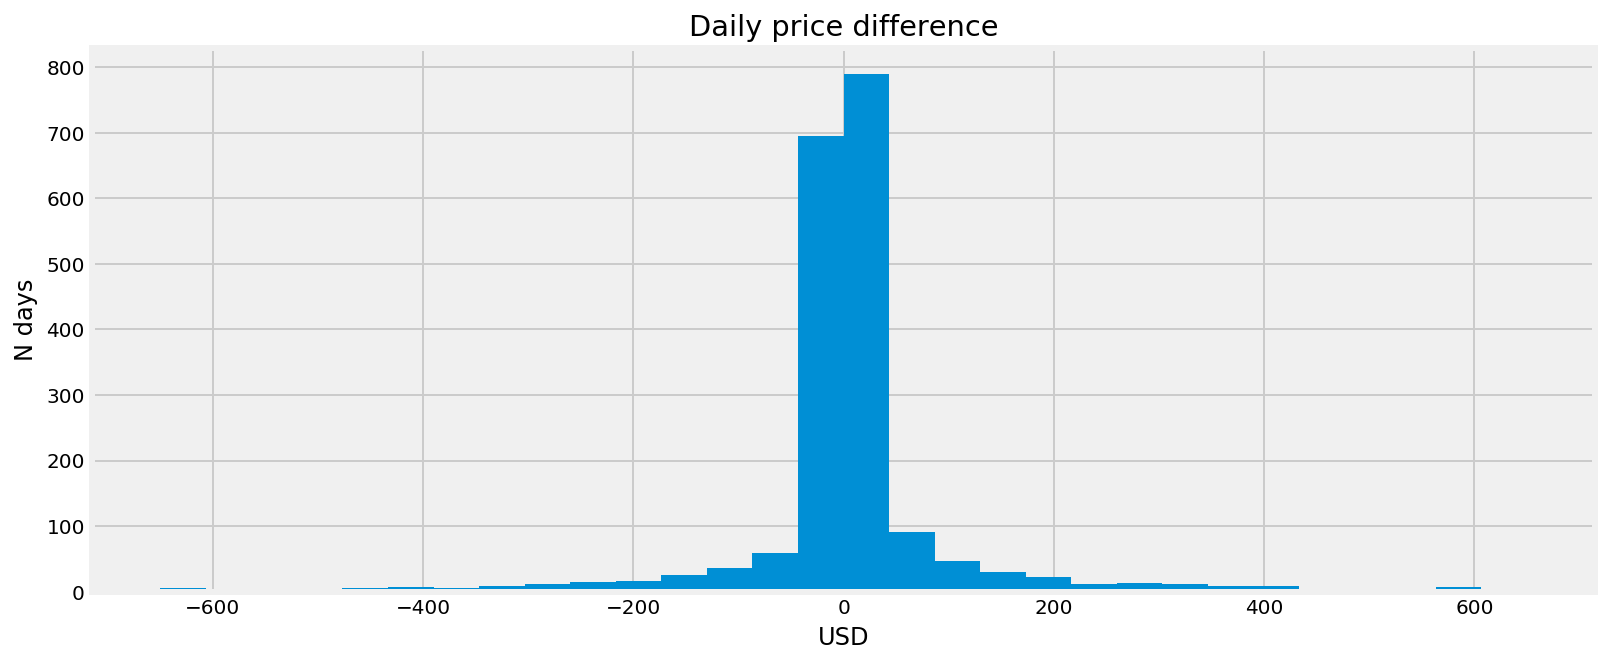

In [33]:
BTC_price['close'].diff()[1:].hist(bins=30, figsize=(12,5), range=[-650,650])
plt.xlabel('USD')
plt.ylabel('N days')
plt.title('Daily price difference')
plt.show()

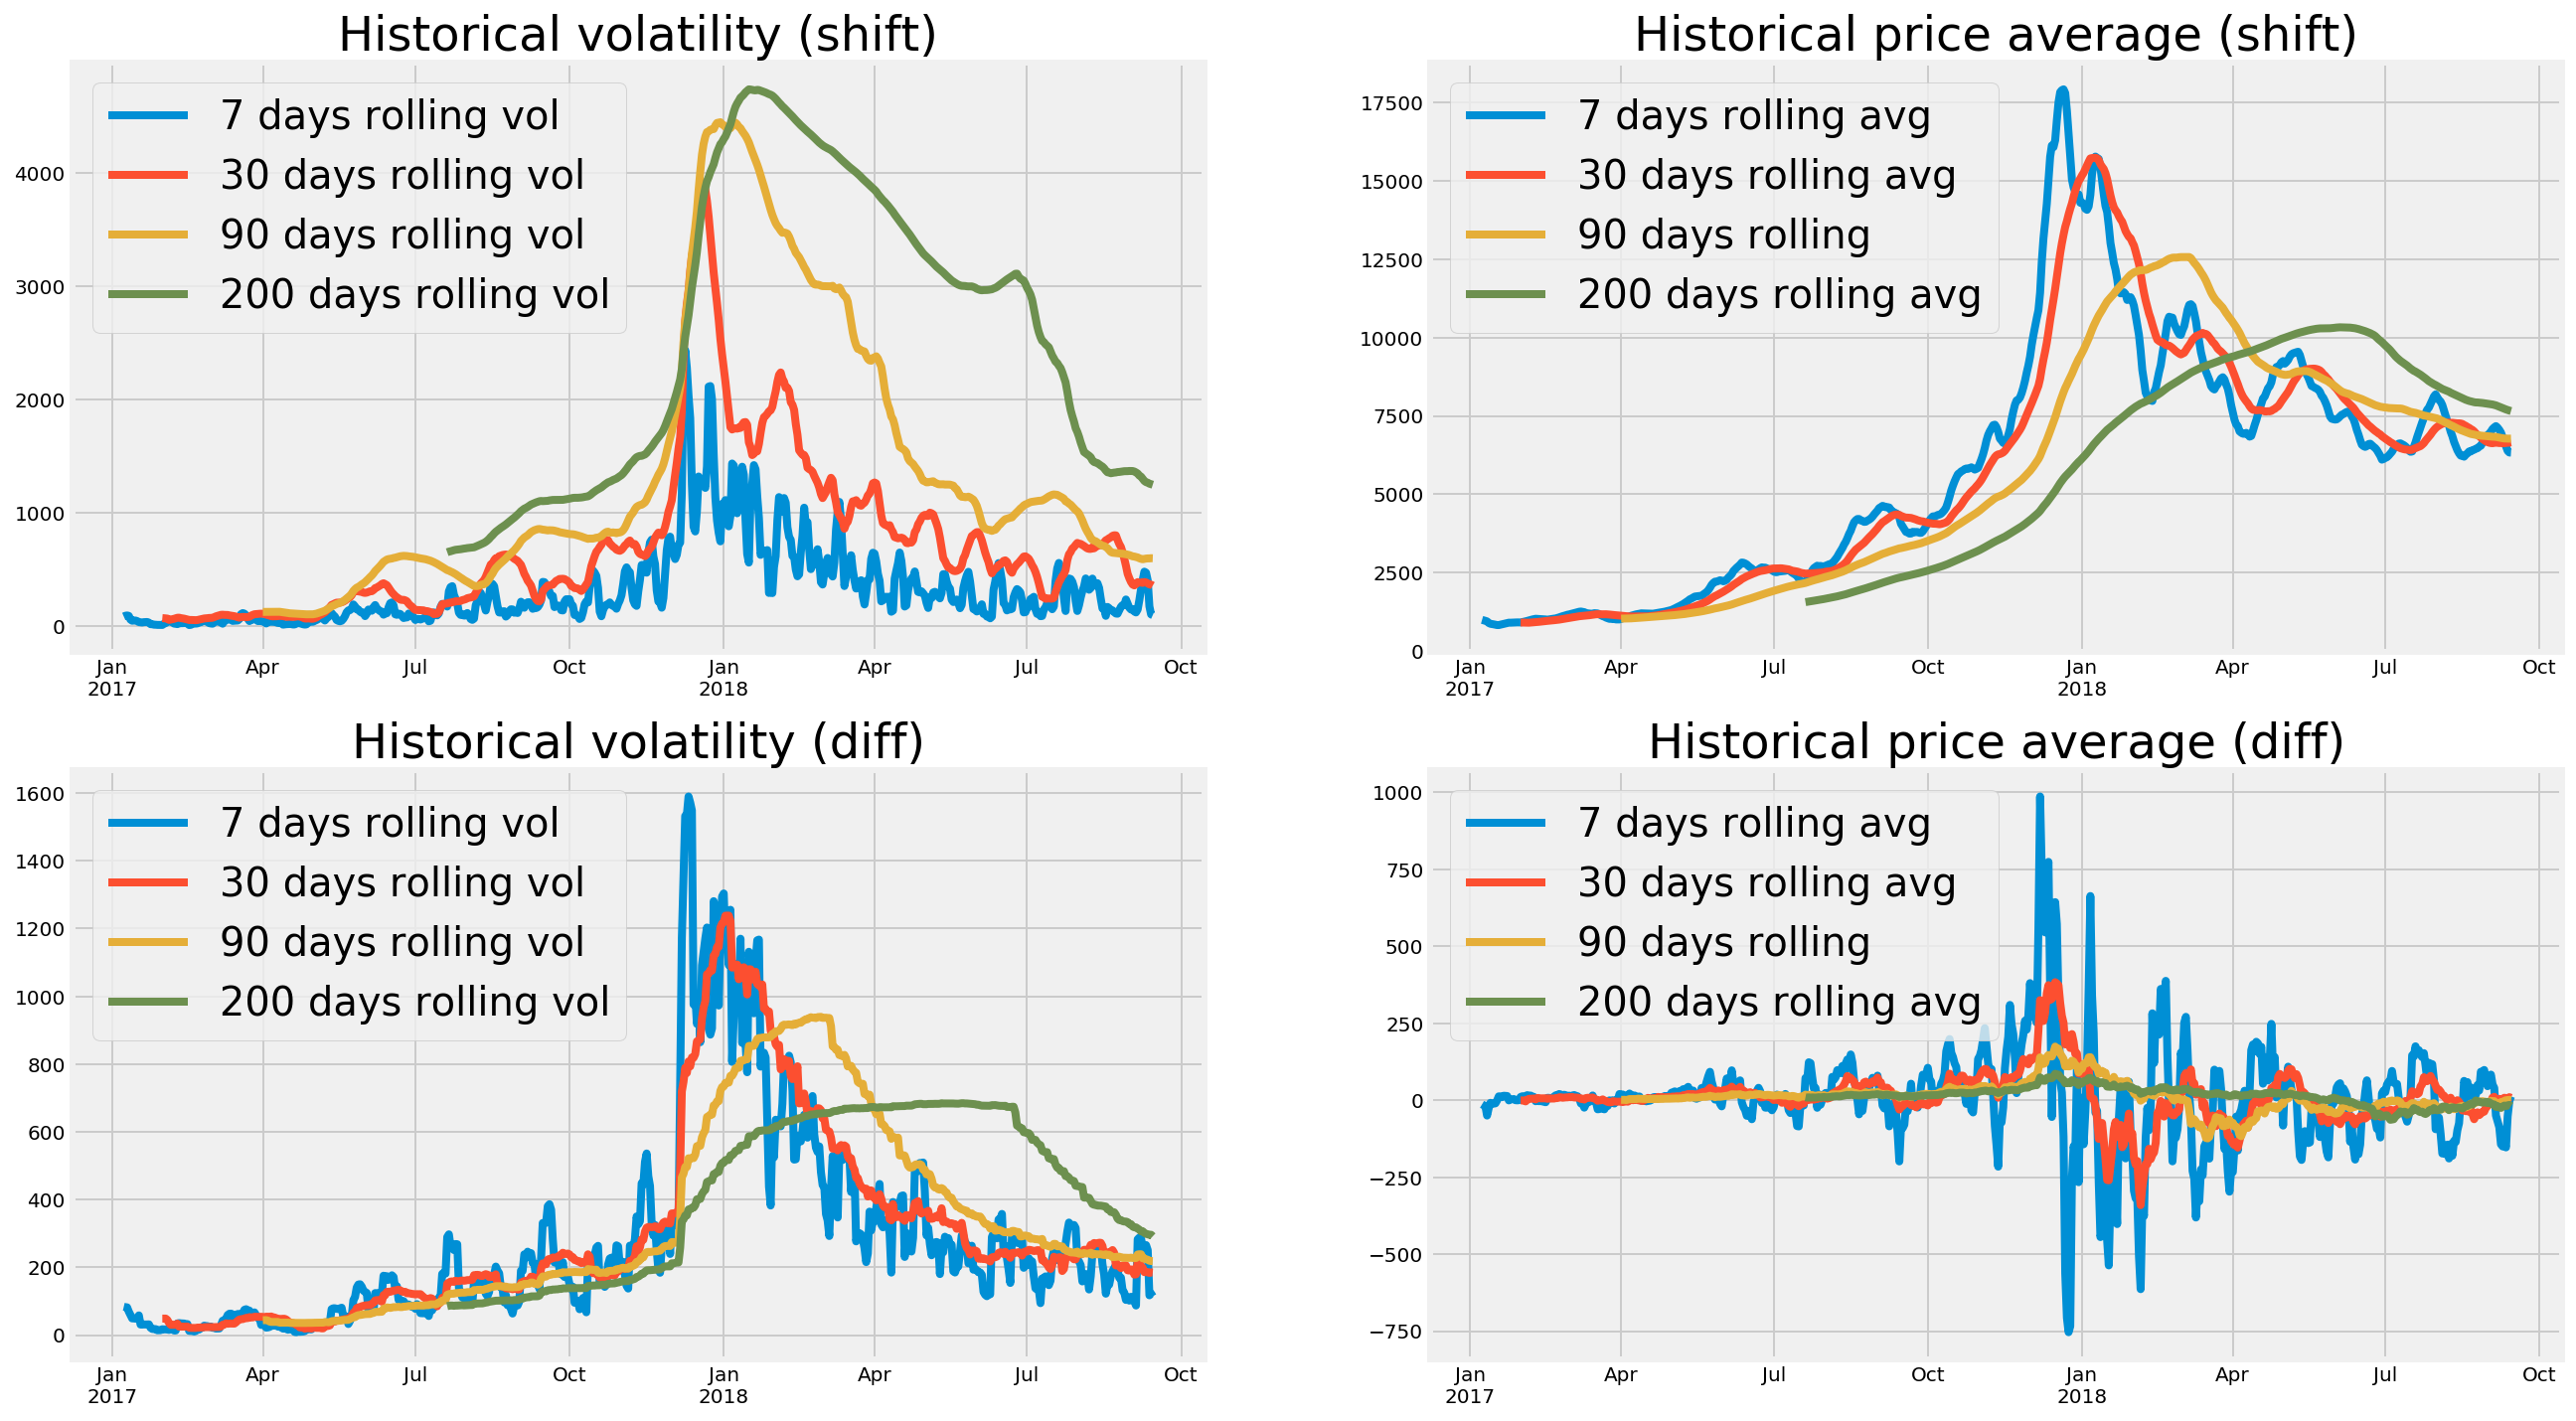

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

# ax[0,0]
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=7).std().dropna().plot(ax=ax[0,0])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=30).std().dropna().plot(ax=ax[0,0])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=90).std().dropna().plot(ax=ax[0,0])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=200).std().dropna().plot(ax=ax[0,0])

ax[0,0].set_title('Historical volatility (shift)',fontsize=24)
ax[0,0].legend(['7 days rolling vol','30 days rolling vol', '90 days rolling vol','200 days rolling vol'], fontsize=20)

# ax[0,1]
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=7).mean().dropna().plot(ax=ax[0,1])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=30).mean().dropna().plot(ax=ax[0,1])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=90).mean().dropna().plot(ax=ax[0,1])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].shift(1).rolling(window=200).mean().dropna().plot(ax=ax[0,1])

ax[0,1].set_title('Historical price average (shift)',fontsize=24)
ax[0,1].legend(['7 days rolling avg','30 days rolling avg', '90 days rolling','200 days rolling avg'], fontsize=20)


# ax[1,0]
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=7).std().dropna().plot(ax=ax[1,0])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=30).std().dropna().plot(ax=ax[1,0])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=90).std().dropna().plot(ax=ax[1,0])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=200).std().dropna().plot(ax=ax[1,0])

ax[1,0].set_title('Historical volatility (diff)',fontsize=24)
ax[1,0].legend(['7 days rolling vol','30 days rolling vol', '90 days rolling vol','200 days rolling vol'], fontsize=20)

# ax[1,1]
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=7).mean().dropna().plot(ax=ax[1,1])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=30).mean().dropna().plot(ax=ax[1,1])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=90).mean().dropna().plot(ax=ax[1,1])
BTC_price.loc[BTC_price.index > '2016-12-31']['close'].diff().rolling(window=200).mean().dropna().plot(ax=ax[1,1])

ax[1,1].set_title('Historical price average (diff)',fontsize=24)
ax[1,1].legend(['7 days rolling avg','30 days rolling avg', '90 days rolling','200 days rolling avg'], fontsize=20)

plt.show()

Let's prove now that the price difference series is stationary, while the price shift is not:

In [35]:
from statsmodels.tsa.stattools import adfuller

In [36]:
dftest = adfuller(BTC_price['close'].diff()[1:])

In [37]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [38]:
print(dftest)

(-8.246938749918126, 5.521599884068663e-13, 26, 1973, {'1%': -3.4336687168076714, '5%': -2.863006019389988, '10%': -2.567550447906854}, 26840.266266966708)


In [39]:
print(dfoutput)

Test Statistic                -8.246939e+00
p-value                        5.521600e-13
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
dtype: float64


Dickey Fuller tests the null hypothesis that the time series follows a unit root process (it is NOT stationary). 

You usually reject the null when the p-value is less than or equal to a specified significance level, often 0.05 (5%), or 0.01 (1%)

DIFF

In this case, we reject the null hypothesis and the series is STATIONARY

In [40]:
dftest = adfuller(BTC_price['close'].shift(1)[1:])

In [41]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [42]:
print(dftest)

(-1.763405158405576, 0.39877531893956464, 23, 1976, {'1%': -3.4336636717018405, '5%': -2.8630037919874423, '10%': -2.567549261922421}, 26856.73564966545)


In [43]:
print(dfoutput)

Test Statistic                   -1.763405
p-value                           0.398775
#Lags Used                       23.000000
Number of Observations Used    1976.000000
dtype: float64


SHIFT

In this case, we accept the null hypothesis and the series is NON STATIONARY

# Features

## Part 1

Ultimately these are the features we started with:

In [44]:
BTC_price.head(10)

,close,high,low,open,volumefrom,volumeto
2013-03-24,71.50,72.50,62.70,64.35,42023.26,2896432.30
2013-03-25,73.60,78.00,69.52,71.50,79743.02,5921197.54
2013-03-26,78.50,79.72,73.11,73.60,56667.38,4377374.22
2013-03-27,88.92,89.50,78.40,78.50,72226.75,6129700.26
2013-03-28,86.18,95.70,75.00,88.92,140263.09,12261153.08
2013-03-29,90.50,93.06,83.01,86.18,83174.56,7384104.11
2013-03-30,92.19,94.98,87.00,90.50,37284.61,3420002.53
2013-03-31,93.03,93.80,91.00,92.19,21129.50,1959050.82
2013-04-01,104.00,106.00,92.24,93.03,90563.17,9060022.27
2013-04-02,117.98,118.36,99.00,104.00,81284.67,8747147.45


Can some of them help us?

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


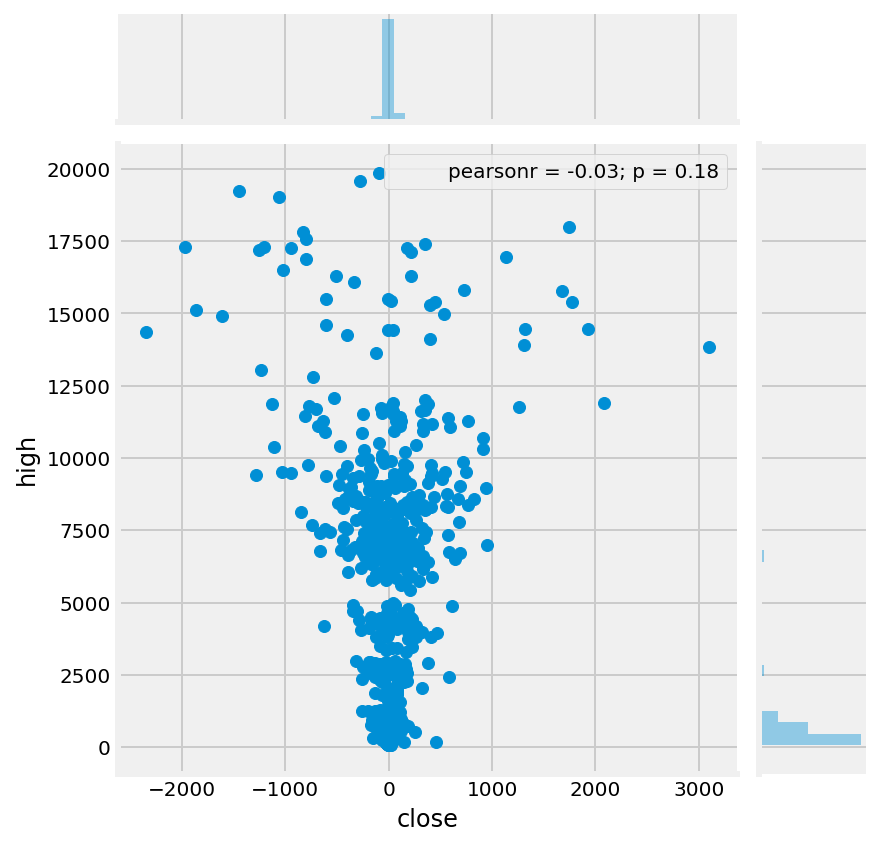

In [45]:
sns.jointplot(BTC_price.close.diff()[1:], BTC_price.high.shift(1)[1:])


In [46]:
lm = linear_model.LinearRegression()

X = BTC_price[['volumeto']].shift(1)[1:] 
y = np.array(BTC_price['close'].diff()[1:])

model = lm.fit(X, y)

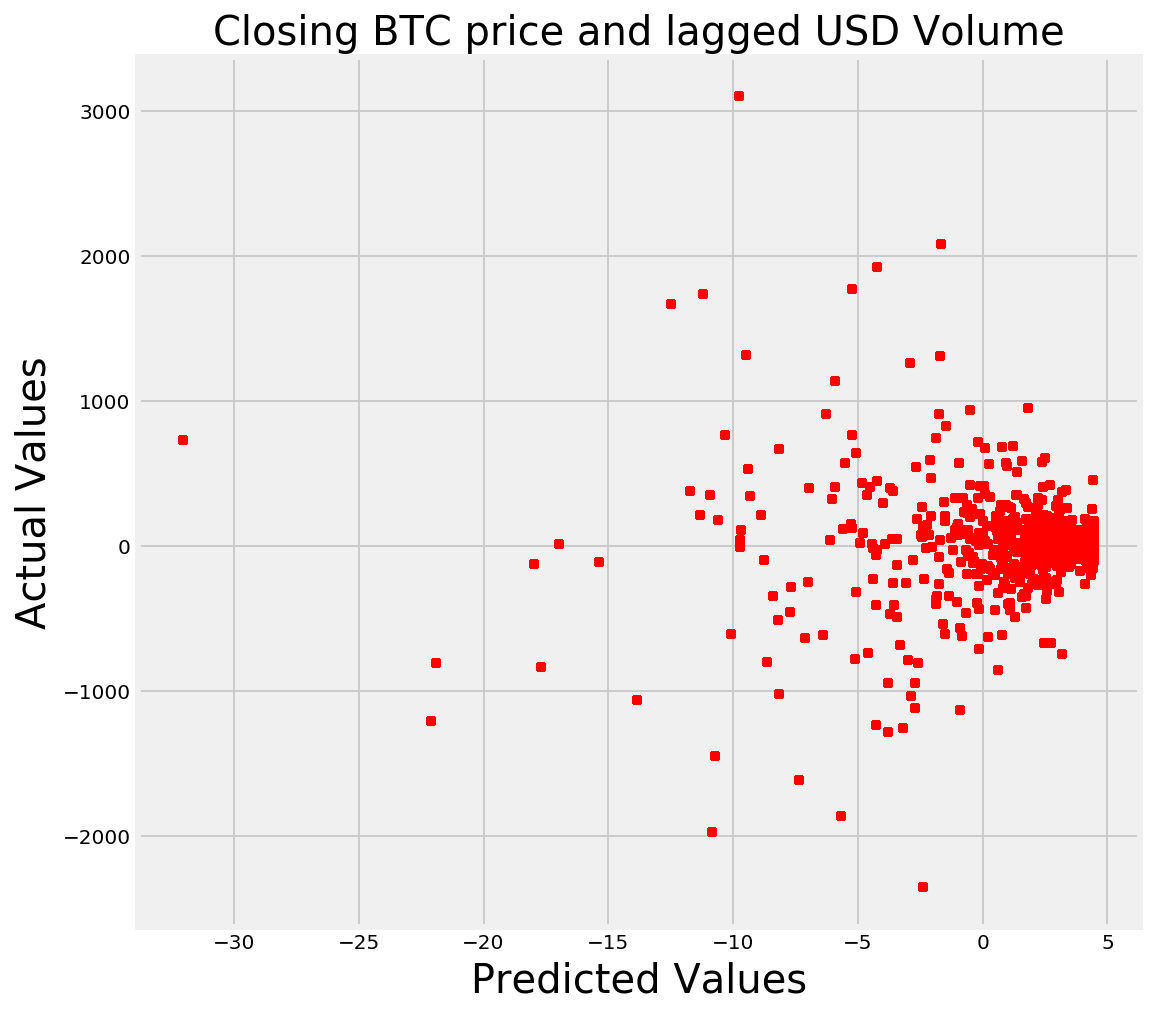

score:  0.0001583652680169356


In [47]:
predictions  =  model.predict(X)
score        =  model.score(X, y)

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.title("Closing BTC price and lagged USD Volume", fontsize=20)
plt.xlabel("Predicted Values", fontsize=20)
plt.ylabel("Actual Values", fontsize=20)
plt.show()

print ("score: ", score)

We know the price difference is a stationary series from before

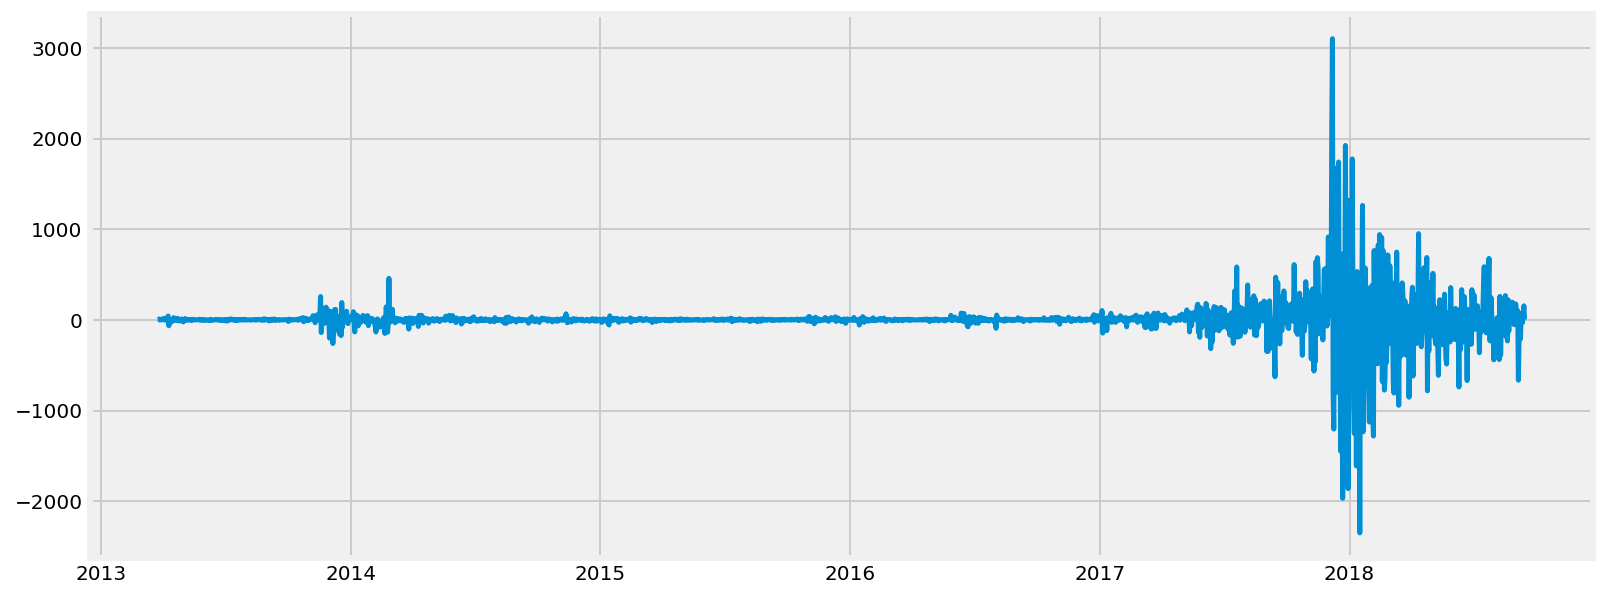

In [48]:
BTC_price['close'].diff().dropna().plot(lw=2.5, figsize=(12,5))
plt.show()

Let us check for seasonality:

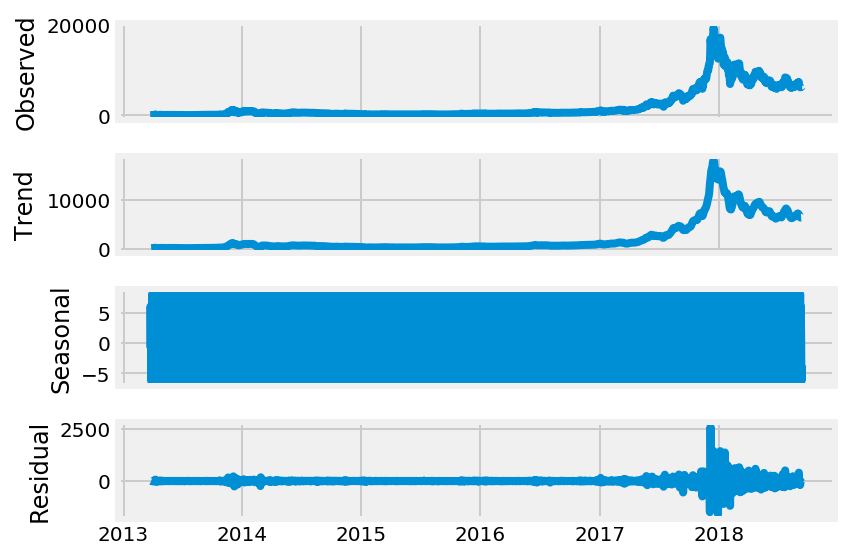

In [49]:
# Price seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(BTC_price['close'])
decomp.plot();

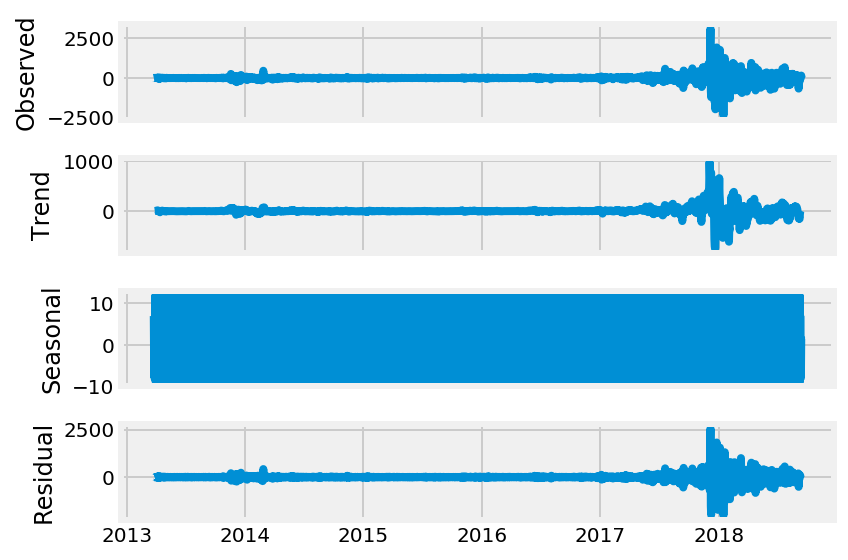

In [50]:
# Price difference seasonal decomposition
decomp = seasonal_decompose(BTC_price['close'].diff()[1:])
decomp.plot();

Let us check autocorrelations and partial autocorrelations:

In [51]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [52]:
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

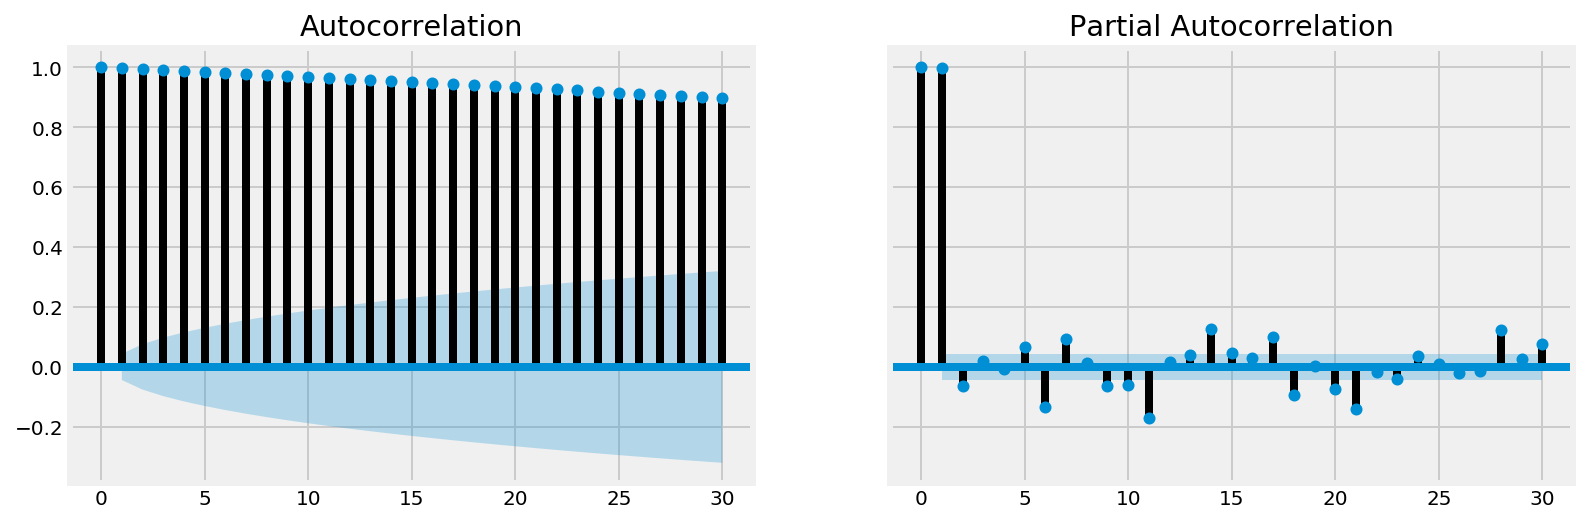

In [53]:
# Price acf and pacf
fig, ax = autocorr_plots(BTC_price['close'],lags=30)
plt.show()

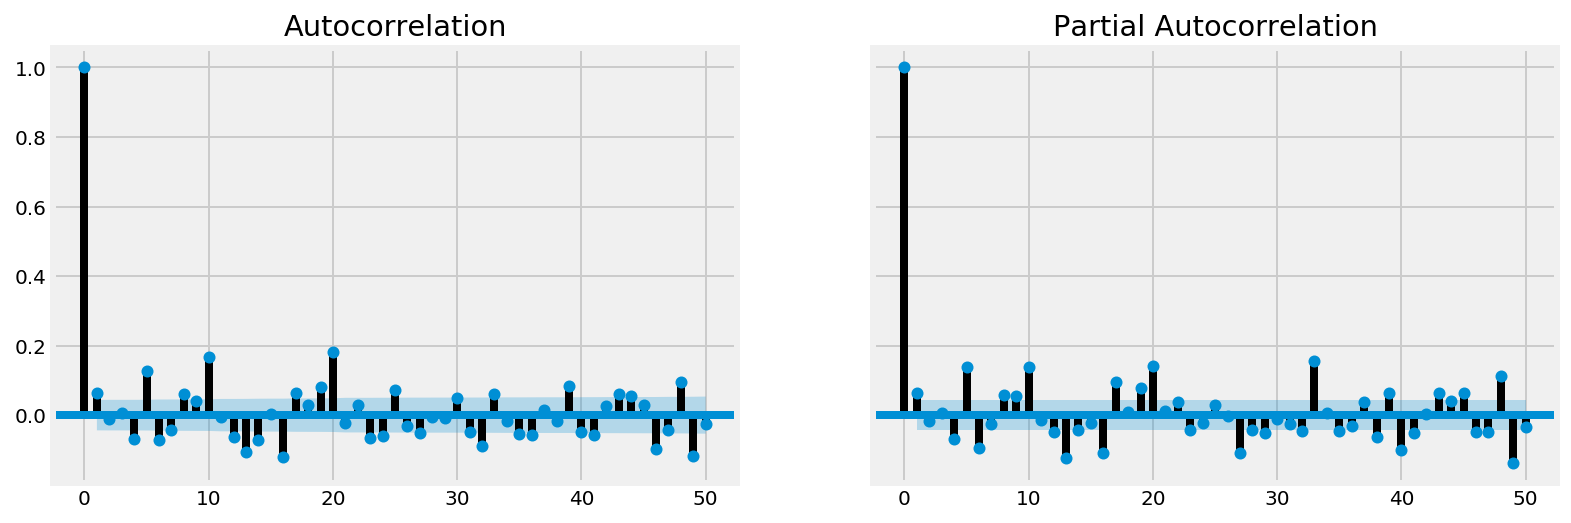

In [54]:
# Price difference acf and pacf
fig, ax = autocorr_plots(BTC_price['close'].diff()[1:],lags=50)
plt.show()

Let us create our variables:

In [55]:
y = pd.DataFrame((BTC_price['close']).diff()>0)*1

In [56]:
X = pd.DataFrame()

In [57]:
X['close_diff_1'] = BTC_price['close'].diff()

In [58]:
X['diff1_rollmean_7'] = X.close_diff_1.rolling(window=7).mean()
X['diff1_rollstd_7'] = X.close_diff_1.rolling(window=7).std()
X['diff1_EWM_mean_7'] = X.close_diff_1.ewm(span=7).mean()
X['diff1_EWM_std_7'] = X.close_diff_1.ewm(span=7).std()

X['diff1_rollmean_14'] = X.close_diff_1.rolling(window=14).mean()
X['diff1_rollstd_14'] = X.close_diff_1.rolling(window=14).std()
X['diff1_EWM_mean_14'] = X.close_diff_1.ewm(span=14).mean()
X['diff1_EWM_std_14'] = X.close_diff_1.ewm(span=14).std()

X['diff1_rollmean_30'] = X.close_diff_1.rolling(window=30).mean()
X['diff1_rollstd_30'] = X.close_diff_1.rolling(window=30).std()
X['diff1_EWM_mean_30'] = X.close_diff_1.ewm(span=30).mean()
X['diff1_EWM_std_30'] = X.close_diff_1.ewm(span=30).std()

X['diff1_rollmean_90'] = X.close_diff_1.rolling(window=90).mean()
X['diff1_rollstd_90'] = X.close_diff_1.rolling(window=90).std()
X['diff1_EWM_mean_90'] = X.close_diff_1.ewm(span=90).mean()
X['diff1_EWM_std_90'] = X.close_diff_1.ewm(span=90).std()

In [59]:
X.dropna(inplace=True)

In [60]:
X.drop('close_diff_1', axis=1, inplace=True)

In [61]:
y = y.iloc[90:]

## Part 2

# Modelling

## Part 1

In [62]:
# Model baseline
y.close.value_counts(normalize=True)

1    0.536368
0    0.463632
Name: close, dtype: float64

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit

In [64]:
# Create a rolling K-fold cross-validation
tscv = TimeSeriesSplit(n_splits=3, max_train_size=None)

In [65]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index].astype('float'), X.iloc[test_index].astype('float')
    y_train, y_test = y.iloc[train_index].astype('float'), y.iloc[test_index].astype('float')

In [66]:
# Standardize the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [67]:
logreg = LogisticRegression()

In [68]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [69]:
# setup the grid search

params = {'penalty':['l1', 'l2'],
          'fit_intercept':[True,False],
          'solver':['liblinear']}

gs = GridSearchCV(estimator=logreg,
                  param_grid=params,
                  cv=None,
                  scoring='accuracy',
                  return_train_score=True)

gs.fit(X_train,y_train)

# extract the grid search results

print('Best Parameters:')
print(gs.best_params_)
# print('Best estimator C:')
# print(gs.best_estimator_.C_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X_train,y_train))
print('Best estimator score on the test set:')
print(gs.score(X_test,y_test))
print('Best estimator coefficients:')
print(gs.best_estimator_.coef_)

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

Best Parameters:
{'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}
Best estimator mean cross validated training score:
0.7336122733612274
Best estimator score on the full training set:
0.7601115760111576
Best estimator score on the test set:
0.7589098532494759
Best estimator coefficients:
[[-7.23085217e-01 -5.13626278e-01  9.14750490e+00  0.00000000e+00
   8.53618413e-01 -4.72946555e-01 -1.10905038e+01  5.87991229e-01
  -8.79874118e-02 -3.66757540e-01  4.50103030e+00  3.08662377e-01
  -4.93912746e-02  0.00000000e+00 -1.85058981e-01 -4.01873917e-03]]


In [70]:
# predictions and pred prob.
yhat = gs.predict(X_test)
yhat_pp = gs.predict_proba(X_test)

In [71]:
def predictions_confusion(model, X, y):

    yhat = model.predict(X)
    yhat_pp = model.predict_proba(X)

    conmat = np.array(confusion_matrix(y, yhat, labels=[1, 0]))

    confusion = pd.DataFrame(conmat, index=['actual_0', 'actual_1'],
                             columns=['predicted_0', 'predicted_1'])
    return yhat, yhat_pp, confusion

In [72]:
yhat, yhat_pp, confusion = predictions_confusion(gs, X_test, y_test)
confusion

,predicted_0,predicted_1
actual_0,180,71
actual_1,44,182


In [73]:
from sklearn.metrics import roc_curve, auc

In [74]:
fpr, tpr, threshold = roc_curve(y_test, yhat_pp[:, 1])
roc_auc = auc(fpr, tpr)

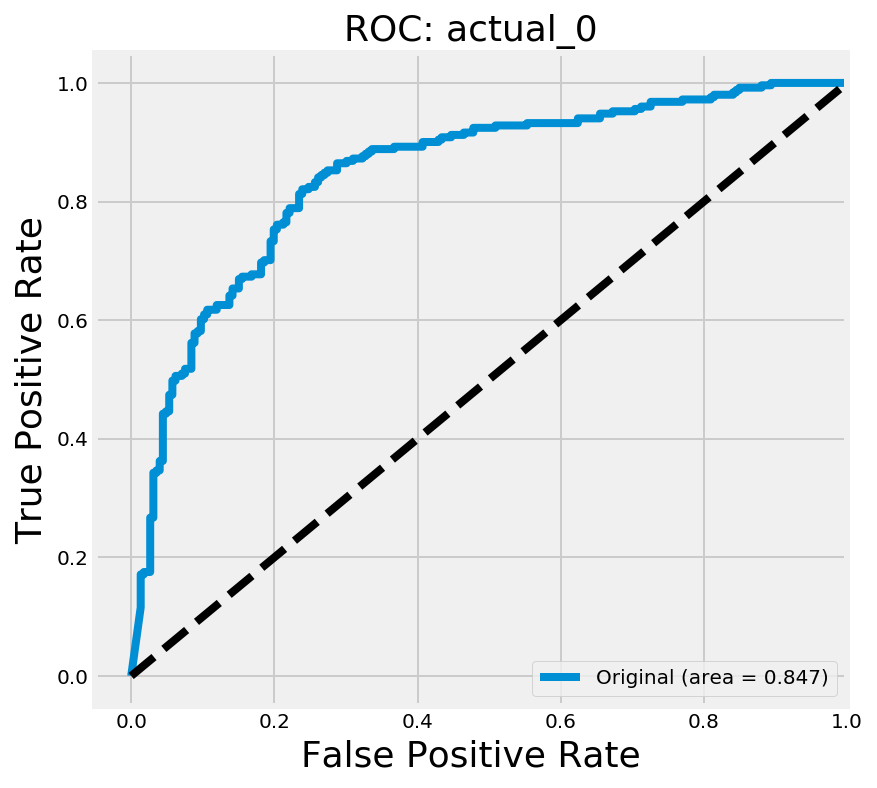

In [75]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, label='Original (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('ROC: actual_0', fontsize=18)
ax.legend(loc="lower right")

plt.show()

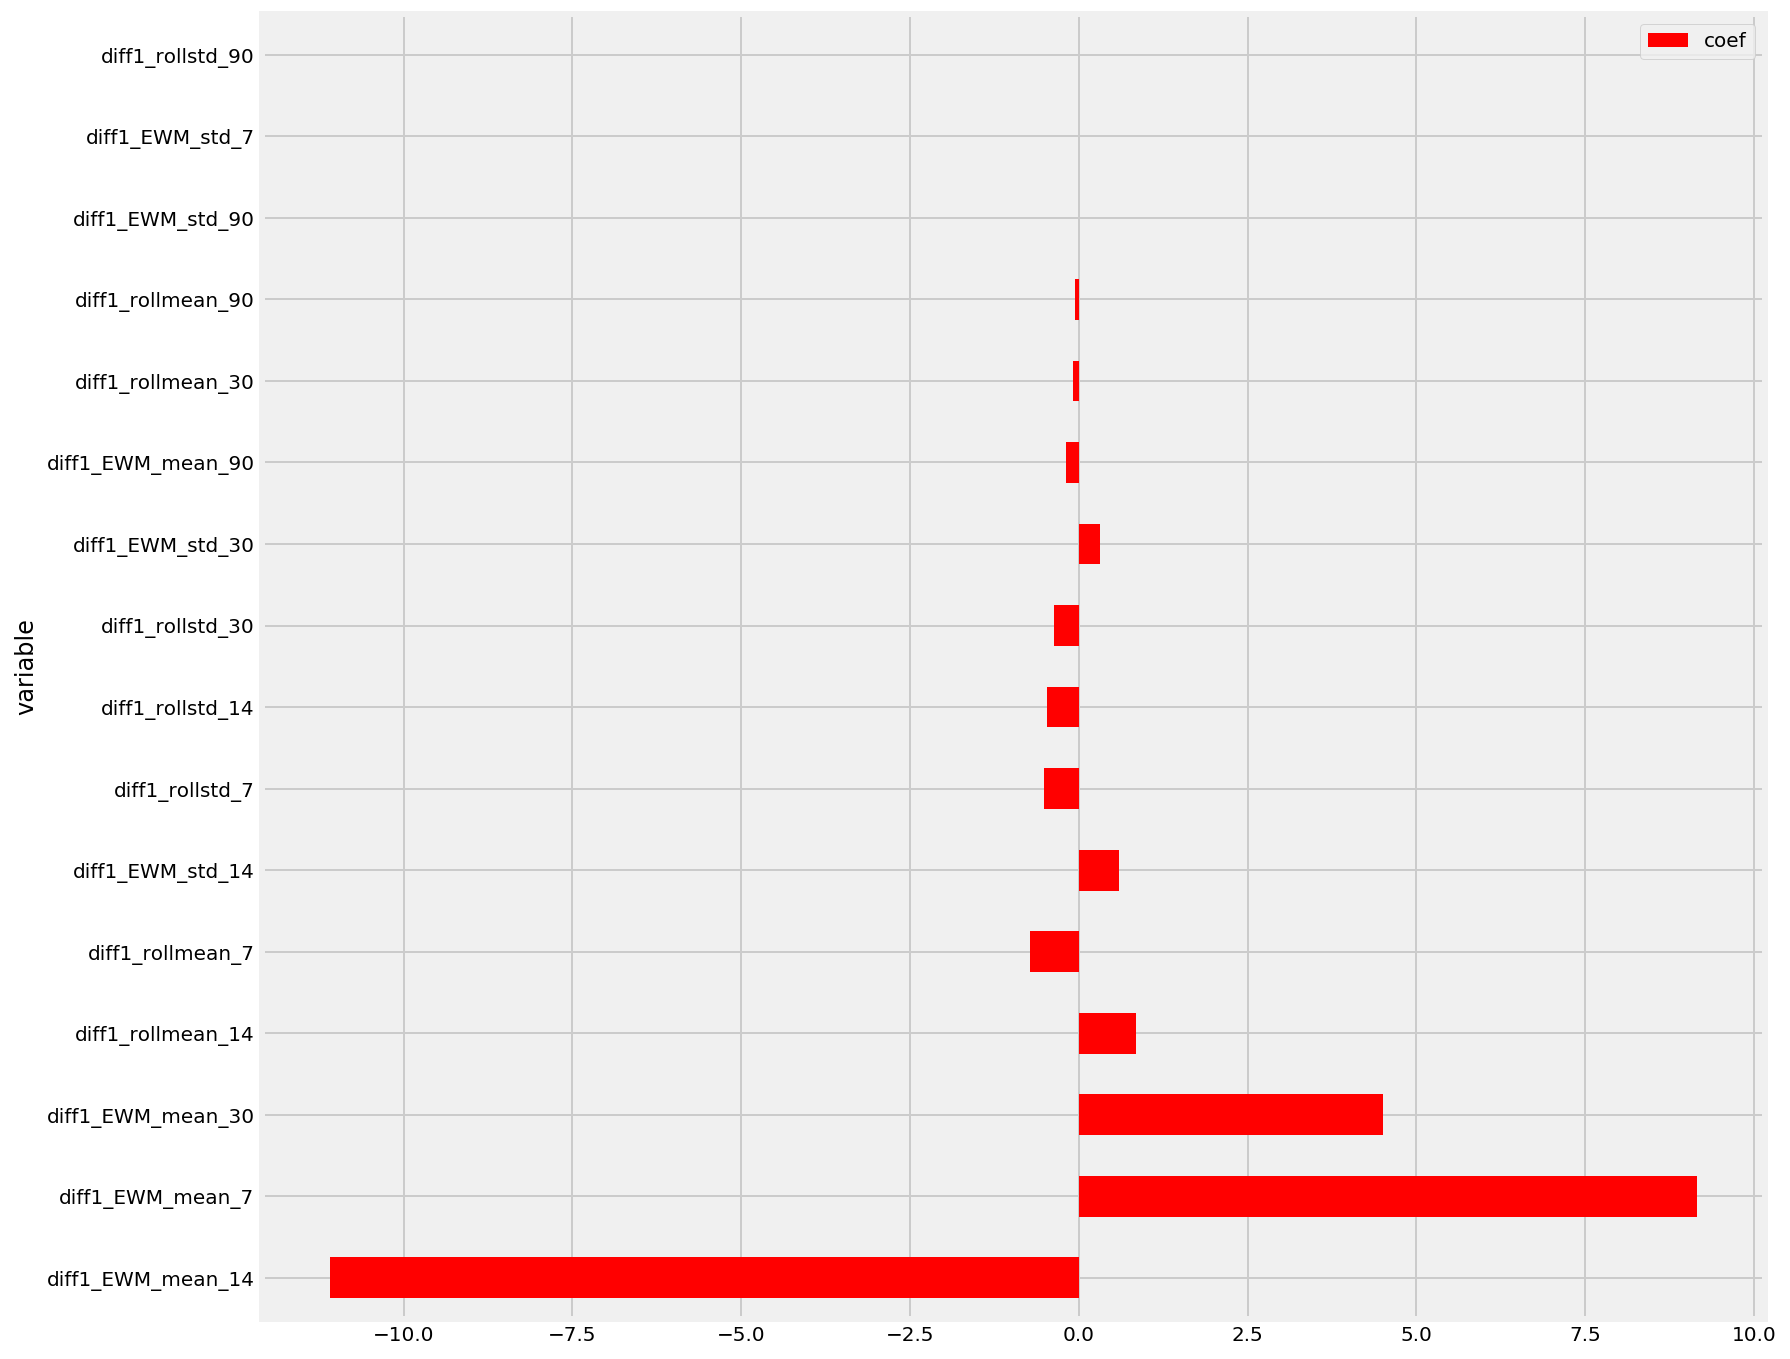

In [76]:
coefs = pd.DataFrame({
    'coef': gs.best_estimator_.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(gs.best_estimator_.coef_[0])
})
coefs.sort_values('abscoef', ascending=False, inplace=True)
coefs.plot(kind='barh',x='variable',y='coef',color='r',figsize=(12,12))
plt.show()

### Random Forest Classifier

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
print('Training accuracy:' ,model.score(X_train, y_train))
print('Test accuracy:', model.score(X_test, y_test))

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training accuracy: 1.0
Test accuracy: 0.710691823899371


### Support Vector Machine

In [79]:
from sklearn import svm, linear_model, datasets
from sklearn.model_selection import cross_val_score

In [80]:
# Let's try a SVM
model = svm.SVC()
model.fit(X_train, y_train)
print('Training accuracy:' ,model.score(X_train, y_train))
print('Test accuracy:', model.score(X_test, y_test))

Training accuracy: 0.7217573221757322
Test accuracy: 0.5031446540880503


/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [87]:
model = svm.SVC(kernel='rbf',decision_function_shape='ovr', probability=True)
#model.fit(X_train, y_train)
# print('Training accuracy:' ,model.score(X_train, y_train))
# print('Test accuracy:', model.score(X_test, y_test))

In [95]:
# setup the grid search

C_range = np.logspace(-3, 2, 6)
gamma_range = np.logspace(-3, 2, 6)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_train, y_train)

# extract the grid search results

print('Best Parameters:')
print(grid.best_params_)
print('Best estimator mean cross validated training score:')
print(grid.best_score_)
print('Best estimator score on the full training set:')
print(grid.score(X_train,y_train))
print('Best estimator score on the test set:')
print(grid.score(X_test,y_test))
print('Best estimator coefficients:')
print(grid.best_estimator_.coef_)

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

Best Parameters:
{'C': 100.0, 'gamma': 0.001}
Best estimator mean cross validated training score:
0.6513249651324965
Best estimator score on the full training set:
0.7168758716875872
Best estimator score on the test set:
0.589098532494759
Best estimator coefficients:


AttributeError: coef_ is only available when using a linear kernel

In [89]:
# predictions and pred prob.
yhat = grid.predict(X_test)
yhat_pp = grid.predict_proba(X_test)

In [90]:
yhat, yhat_pp, confusion = predictions_confusion(grid, X_test, y_test)
confusion

,predicted_0,predicted_1
actual_0,100,151
actual_1,45,181


In [91]:
fpr, tpr, threshold = roc_curve(y_test, yhat_pp[:, 1])
roc_auc = auc(fpr, tpr)

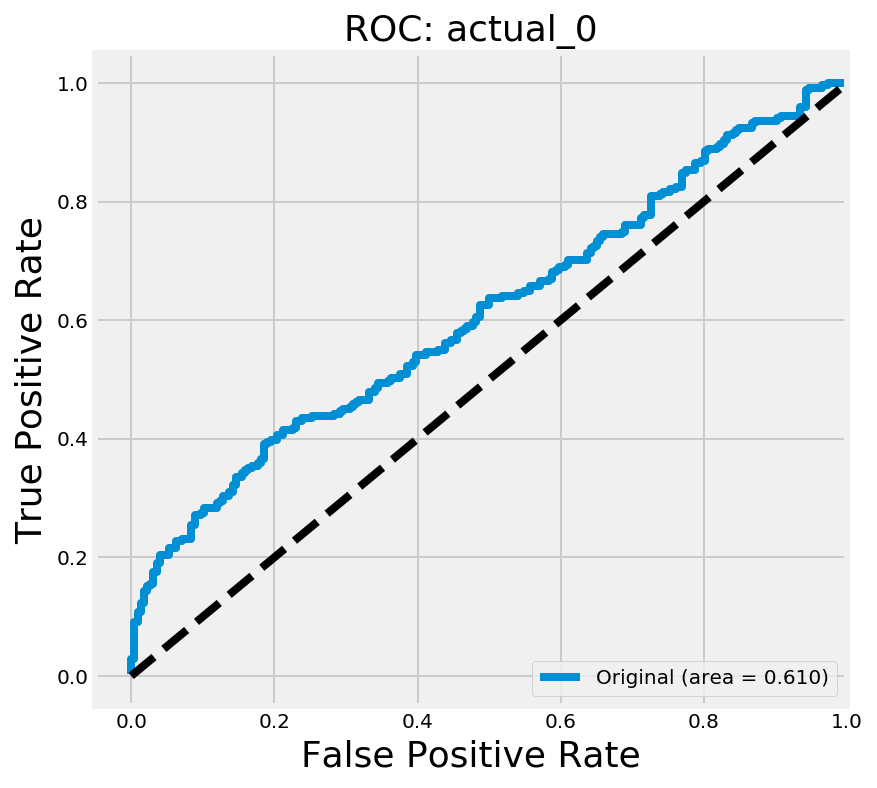

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, label='Original (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('ROC: actual_0', fontsize=18)
ax.legend(loc="lower right")

plt.show()

### Arima

In [96]:
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information w

{'aic':               0             1             2             3             4  \
0           NaN  27413.335865  27414.855380  27415.803963  27403.532687   
1  27413.591145  27401.693278  27403.693025  27402.097411  27387.855401   
2  27415.053823  27403.692988  27405.013457  27406.856718  27363.414380   
3  27416.962637  27400.980092  27406.832251  27321.131964  27349.584231   
4  27409.589881  27384.473535  27345.955814  27351.150219  27298.676942   
5  27373.657432  27365.781924  27359.299973  27349.230648  27246.962444   

              5  
0  27376.199413  
1  27375.995715  
2  27363.709511  
3  27364.531941  
4  27252.033717  
5  27242.637372  , 'bic':               0             1             2             3             4  \
0           NaN  27424.537670  27431.658088  27438.207573  27431.537199   
1  27424.792950  27418.495985  27426.096635  27430.101923  27421.460816   
2  27431.856530  27426.096598  27433.017969  27440.462133  27402.620697   
3  27439.366247  27428.984604  2

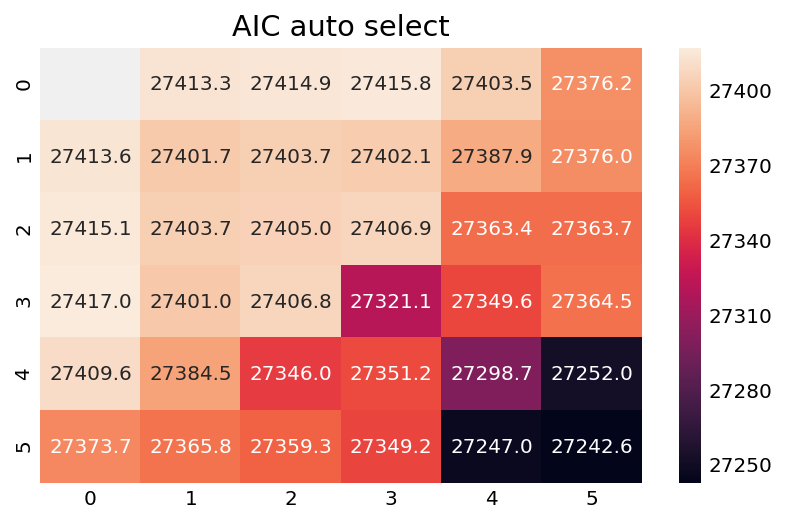

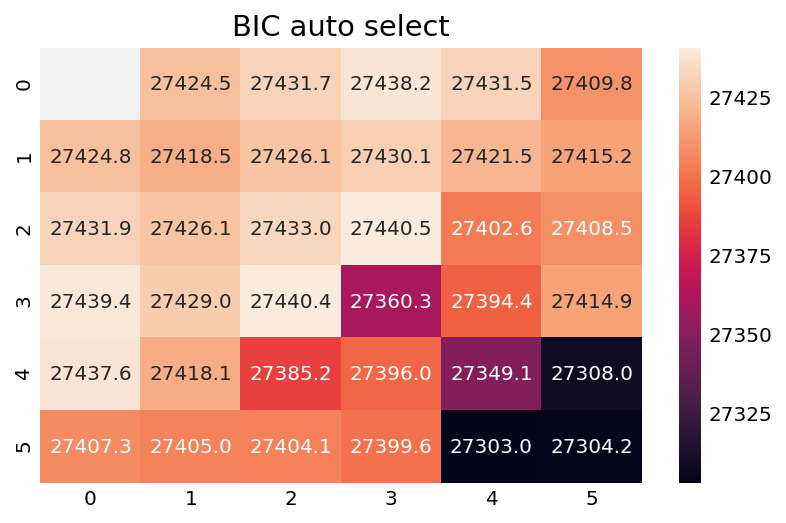

In [97]:
from statsmodels.tsa import stattools
auto_select = stattools.arma_order_select_ic(
    BTC_price['close'].diff()[1:], max_ar=5, max_ma=5, ic=['aic', 'bic'], trend='nc')

print(auto_select)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.title('AIC auto select')
plt.show()

sns.heatmap(auto_select['bic'], annot=True, fmt='.1f')
plt.title('BIC auto select')
plt.show()

In [98]:
#Let's fit our best model according to BIC, ARMA(5,4)

model = ARMA(BTC_price['close'].diff()[1:],order=(5,4))
result = model.fit(start_params=[0,0,0,0,0,0,0,0,0],solver='lbfgs',method='css',trend='nc',ic='BIC')
# without setting start_params it might not succeed in finding the MLE
# requires as many start_params as model parameters, i.e. p+q
result.summary2()

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 27237.7046
Dependent Variable: close            Log-Likelihood:      -13581.   
Date:               2018-09-14 03:16 Scale:               1.0000    
No. Observations:   2000             Method:              css       
Df Model:           9                Sample:              03-30-2013
Df Residuals:       1986                                  09-14-2018
Converged:          1.0000           S.D. of innovations: 218.877   
No. Iterations:     111.0000         HQIC:                27202.279 
AIC:                27181.7206                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
ar.L1.close      0.2773    0.0424    6.5435  0.0000   0.1942   0.3603
ar.L2.close      0.7212    0.0385   18.7539  0.0000   0.6458   0.7965
ar.L3.close     -0.1160    0.0354   -3.2716  0.0011  -0.1854  -0.0465
ar.L4.close     -0.8221    0.0283  -29.0123  0.0000  -0.8777  -0.7666
ar.L5.close      0.1844    0.0247    7.4685  0.0000   0.1360   0.2328
ma.L1.close     -0.2227    0.0386   -5.7725  0.0000  -0.2983  -0.1471
ma.L2.close     -0.8070    0.0483  -16.7131  0.0000  -0.9016  -0.7123
ma.L3.close      0.0818    0.0392    2.0835  0.0373   0.0048   0.1587
ma.L4.close      0.7929    0.0327   24.2102  0.0000   0.7287   0.8571
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -0.8684            -0.5952           1.0528            -0.4044
AR.2           -0.8684             0.5952           1.0528             0.4044
AR.3            0.8997            -0.5510           1.0550            -0.0875
AR.4            0.8997             0.5510           1.0550             0.0875
AR.5            4.3956            -0.0000           4.3956            -0.0000
MA.1            0.8794            -0.4954           1.0093            -0.0816
MA.2            0.8794             0.4954           1.0093             0.0816
MA.3           -0.9309            -0.6095           1.1127            -0.4077
MA.4           -0.9309             0.6095           1.1127             0.4077
====================================================================

"""

In [99]:
from sklearn.metrics import mean_squared_error

In [100]:
print('MSE sklearn:\t\t', mean_squared_error(BTC_price['close'].diff()[6:], result.fittedvalues[:]))
print('MSE statsmodels:\t', result.sigma2)

MSE sklearn:		 47907.17033439273
MSE statsmodels:	 47907.17033439283


In [101]:
# compare to baseline
mean_squared_error(BTC_price['close'].diff()[6:], [BTC_price['close'].diff()[6:].mean()] * len(BTC_price['close'].diff()[6:]))

52751.535523050086

In [109]:
Xarima = pd.DataFrame(result.fittedvalues[84:])

In [111]:
for train_index, test_index in tscv.split(Xarima):
    Xarima_train, Xarima_test = Xarima.iloc[train_index].astype('float'), Xarima.iloc[test_index].astype('float')
    y_train, y_test = y.iloc[train_index].astype('float'), y.iloc[test_index].astype('float')

In [112]:
# Standardize the data
scaler = StandardScaler()

Xarima_train = np.array(Xarima_train).reshape((len(Xarima_train),1))
Xarima_test = np.array(Xarima_test).reshape((len(Xarima_test),1))

Xarima_train = scaler.fit_transform(Xarima_train)
Xarima_test = scaler.transform(Xarima_test)

In [117]:
print(Xarima_train.shape, Xarima_test.shape, y_train.shape, y_test.shape)

(1434, 1) (477, 1) (1434, 1) (477, 1)


In [122]:
model_lr = LogisticRegression()

In [123]:
# setup the grid search

params = {'penalty':['l1', 'l2'],
          'fit_intercept':[True,False],
          'solver':['liblinear']}

gs_arima = GridSearchCV(estimator=model_lr,
                  param_grid=params,
                  cv=None,
                  scoring='accuracy',
                  return_train_score=True)

gs_arima.fit(Xarima_train,y_train)

# extract the grid search results

print('Best Parameters:')
print(gs_arima.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_arima.best_score_)
print('Best estimator score on the full training set:')
print(gs_arima.score(Xarima_train,y_train))
print('Best estimator score on the test set:')
print(gs_arima.score(Xarima_test,y_test))
print('Best estimator coefficients:')
print(gs_arima.best_estimator_.coef_)

Best Parameters:
{'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Best estimator mean cross validated training score:
0.5495118549511855
Best estimator score on the full training set:
0.5453277545327755
Best estimator score on the test set:
0.48846960167714887
Best estimator coefficients:
[[-0.06571866]]


/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

# Evaluation

In [124]:
from scipy import stats
import statsmodels.api as sm

def residual_plot(res):
    resid_standard = (res - res.mean()) / res.std()

    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1], lags=50)

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

/Users/lorenzopalmieri/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


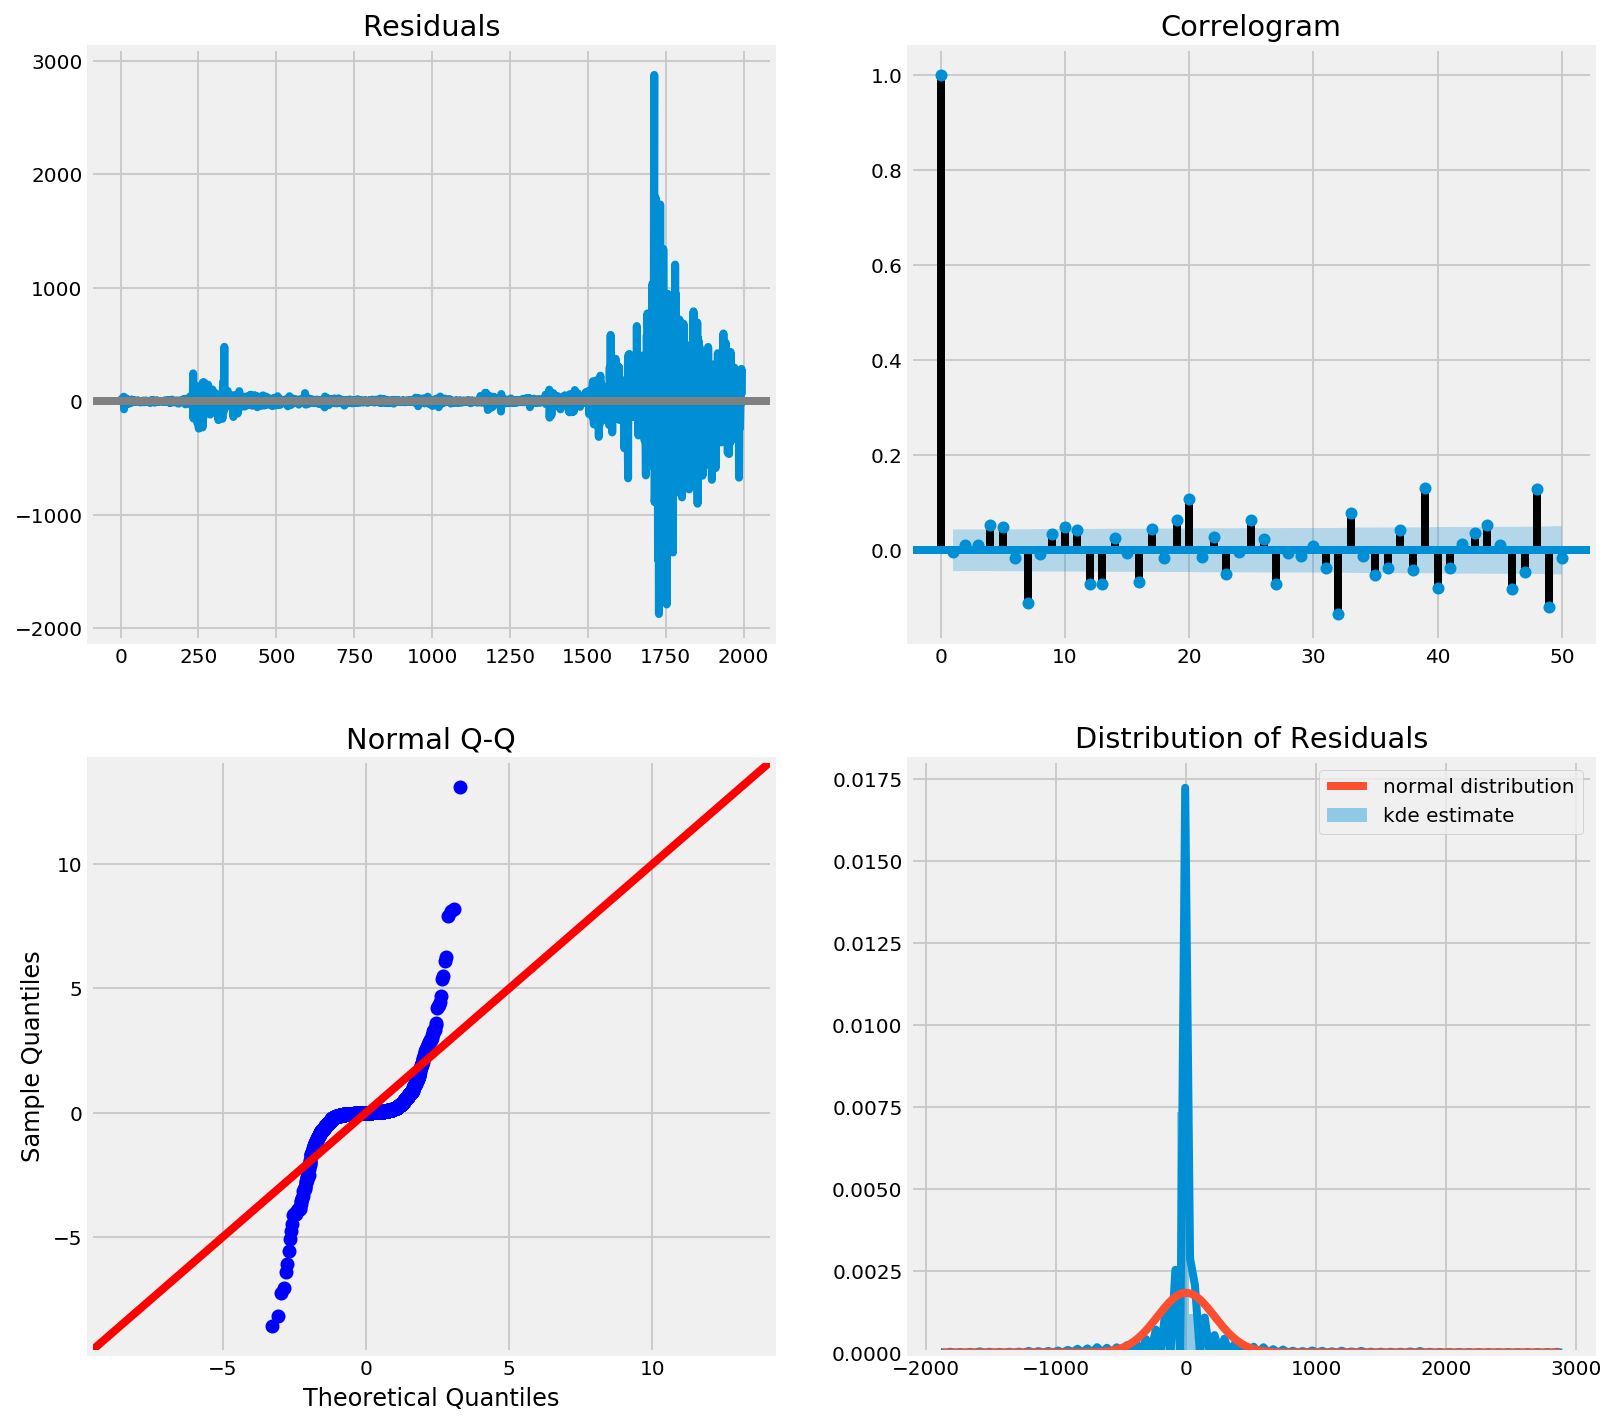

In [126]:
residual_plot(result.resid.values)

# Conclusions